In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
plt.rcParams["font.family"] = ["Times New Roman"]


In [ ]:
save = False

In [ ]:

path =Path(f"./data/model_runs/models/tuner_run_002/tune_results/train_bicycle_2025-07-20_14-27-23")
df = None
metric = "nll"
for dir in path.iterdir():
    if dir.is_dir():
        print(dir.name)
        with open(dir/"result.json", "r") as rf:
            result = pd.read_json(rf.readline())
            for line in rf.readlines():
                line = pd.read_json(line)
                result = pd.concat([result, line], axis=0)
        result = result.reset_index(drop=True)
        best_result = result.iloc[result[metric].argmin()]
        print(best_result)
        if df is None:
            df = pd.DataFrame(columns=result.columns)
        df.loc[dir.name] = best_result

In [ ]:
# processing
df = df.convert_dtypes()
if "config" in df.columns:
    for k, v in df["config"].iloc[0].items():
        df[k] = df["config"].map(lambda x: x[k])


In [ ]:
df

In [ ]:

# look at the total experiment
threshold = 10

df_th = df[df[metric]< threshold]
df_th = df_th[[c for c in df_th.columns if "scale" in c or c==metric]]
corr = df_th.corr(method="spearman")
corr

p_df = corr.copy()
for x in df_th.columns:
    for y in df_th.columns:
        p = pearsonr(df_th[x], df_th[y])[1]
        p_df.loc[x,y] = p
p_df
df_th[metric] = df_th[metric].astype(float)
a = 0.05
corr_annot = corr.to_numpy().round(3).astype(str)
for (x,y), p in np.ndenumerate(p_df):
    if  x!=y and p < a:
        ann = "*"
        ann += "".join(["*" for n in np.logspace(-2, -5, num=4) if p<n])
        corr_annot[x,y] += ann



plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=corr_annot, cmap="coolwarm",fmt="", square=True, annot_kws={"color":"black"}, cbar=False)
plt.yticks(rotation=0)
plt.title("Correlation of Hyperparameters")
if save:
    print("Saving!")
    df_th.to_csv("./presentation/HyperparameterCorrelation.csv")
    plt.savefig("./presentation/HyperparameterCorrelation.pdf")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
grid = sns.pairplot(
    df_th,
    hue=metric,
    palette="coolwarm",
    diag_kind="kde",
    corner=False)


In [ ]:
# find the best run
results = pd.read_csv(path.parent.parent/"results_df.csv", index_col=0)
results = results.dropna(axis=1, how="all")
results = results[~results["final_nll"].isna()].sort_values("final_nll")
#results = results[[c for c in results.columns if "config" in c or "nll" in c]]

In [ ]:
def get_log_path(d : pd.Series, dir = path):
    p = "train_bicycle_" + d["logdir"]
    possible_paths = dir.glob(p+"*")
    return possible_paths.__next__()
def extract_json_results(dir):
    with open(dir/"result.json", "r") as rf:
        result = pd.read_json(rf.readline())
        for line in rf.readlines():
            line = pd.read_json(line)
            result = pd.concat([result, line], axis=0)
    return result.reset_index(drop=True)

In [198]:
from matplotlib.ticker import ScalarFormatter

def complete_result(d : pd.Series):
    p = get_log_path(d)
    res = extract_json_results(p)
    cols = d[d.isna()].index
    matches = [c for c in cols if c in res.columns]
    print(matches)
    res = res[matches+["training_iteration"]].dropna(axis=0, how="any")
    last_res = res.loc[[res["training_iteration"].idxmax()], :]
    # Ensure shapes match for assignment
    d.loc[matches] = last_res[matches].iloc[0].values
    return d

def plot_training(d:pd.Series):
    p = get_log_path(d)
    res = extract_json_results(p)
    fig, ax = plt.subplots(figsize = (10,10), ncols=4)
    ax = ax.flatten()
    ax[0].plot(res["training_iteration"], res["nll"], color = "salmon")
    ax[0].set_title("Validation NLL")
    ax[0].set_xlabel("Training Iteration")
    ax[1].plot(res["training_iteration"], res["average_precision"], color = "skyblue")
    ax[1].set_title("Validation Precision")
    ax[1].set_xlabel("Training Iteration")
    ax[1].plot([], [], " ", label = res["config"].iloc[0])
    for c, n in d[[c for c in d.index if "final" in c]].items():
        ax[2].bar(c.split("_")[-1], n)
        ax[2].text(c.split("_")[-1], n + 0.01, f"{n:.2f}", ha='center', va='bottom', fontsize=9)

    ax[2].set_title("Test Set Performance")
    
    for a in ax:
        a.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        a.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))

    table_data = [[k, f"{v:.3g}"] for k, v in res['config'].iloc[0].items()]
    ax[3].axis("off")
    table = ax[3].table(cellText=table_data, colLabels=["Hyperparameter", "Value"],
        loc="center", #bbox=[0.3, -0.5, 0.4, 0.3]
        )
    table.scale(1,7.5)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    ax[3].set_title("Best Configuration")


    fig.suptitle("Hyperparameter Tuning Results", fontsize=16, y=1.02)
    fig.tight_layout(rect=[0, 0.05, 1, 0.98])
    


In [ ]:
results = results.apply(complete_result, axis=1)

In [209]:
results.sort_values("final_average_precision", ascending=False).iloc[1]

nll                                                   2.810073
timestamp                                           1753045829
done                                                     False
training_iteration                                          52
trial_id                                              a75fef94
date                                       2025-07-20_23-10-29
time_this_iter_s                                     10.603291
time_total_s                                       1786.279157
pid                                                    2465710
hostname                                            b260-pc008
node_ip                                          172.27.25.132
time_since_restore                                 1786.279157
iterations_since_restore                                    52
config/train_loop_config/lr                           9.113476
config/train_loop_config/scale_l1                     2.860296
config/train_loop_config/scale_spectral               0

/tmp/ipykernel_2688443/3624219012.py:7: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  result = pd.read_json(rf.readline())
/tmp/ipykernel_2688443/3624219012.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_2688443/3624219012.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_2688443/3624219012.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  line = pd.read_json(line)
/tmp/ipykernel_2688443/3624219012.py:9: F

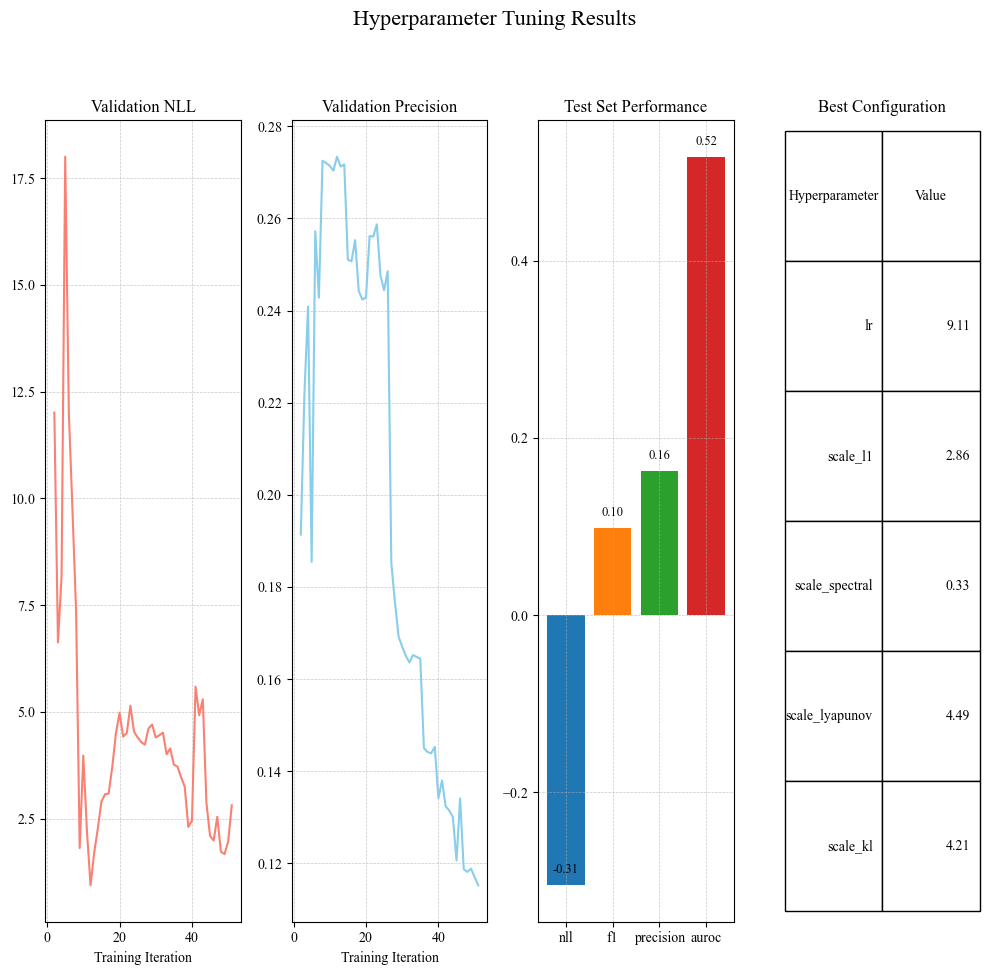

In [213]:
plot_training(results.sort_values("final_nll", ascending=True).iloc[0])

In [196]:
results

,nll,timestamp,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,...,config/train_loop_config/scale_l1,config/train_loop_config/scale_spectral,config/train_loop_config/scale_lyapunov,config/train_loop_config/scale_kl,average_precision,final_nll,final_max_f1,final_average_precision,final_auroc,logdir
94,2.810073,1753045829,False,52,a75fef94,2025-07-20_23-10-29,10.603291,1786.279157,2465710,b260-pc008,...,2.860296,0.329781,4.486829,4.211437,0.115241,-0.305306,0.098361,0.162822,0.517663,a75fef94
77,10.149932,1753040819,False,52,c70fb15a,2025-07-20_21-46-59,10.489599,1828.026017,2242468,b260-pc008,...,7.394460,1.577922,0.604462,5.826369,0.110375,-0.129206,0.129032,0.107793,0.427989,c70fb15a
55,1.697637,1753033722,False,52,14a8f120,2025-07-20_19-48-42,10.900757,1905.012976,1955447,b260-pc008,...,2.225581,0.446847,5.095342,6.653404,0.094966,1.320864,0.095238,0.088650,0.459239,14a8f120
19,20.974556,1753024643,False,52,e6fdcd66,2025-07-20_17-17-23,11.198209,1991.311262,1601862,b260-pc008,...,5.941468,7.483390,7.500112,9.039038,0.075829,1.994606,0.111111,0.086066,0.434783,e6fdcd66
64,-1.243906,1753036725,False,52,4a91a59f,2025-07-20_20-38-45,10.763026,1799.941669,2072249,b260-pc008,...,8.315123,9.796264,8.676862,6.153076,0.220118,3.682467,0.133333,0.212968,0.536685,4a91a59f
7,1.818022,1753019456,False,52,69d6928a,2025-07-20_15-50-56,10.967422,1989.509964,1423472,b260-pc008,...,0.985744,4.407123,6.845488,3.053092,0.065664,4.629681,0.117647,0.073113,0.418478,69d6928a
74,3.651106,1753038987,False,52,9b7fb625,2025-07-20_21-16-27,11.275561,1760.465101,2175453,b260-pc008,...,6.543108,9.090453,8.887605,8.092625,0.100788,4.686996,0.122449,0.083413,0.407609,9b7fb625
12,1.193255,1753022228,False,52,819a49df,2025-07-20_16-37-08,10.959275,1983.228750,1513396,b260-pc008,...,4.214130,7.769371,7.106648,2.986962,0.081277,5.243855,0.095238,0.095661,0.432065,819a49df
1,53.428213,1753016438,False,52,94e90bf7,2025-07-20_15-00-38,11.482918,1987.071653,1315523,b260-pc008,...,8.663100,7.083645,6.015139,0.590255,0.097174,8.029076,0.109091,0.101943,0.562500,94e90bf7
0,10.720714,1753016422,False,52,6e9b720b,2025-07-20_15-00-22,10.972800,1973.464310,1315327,b260-pc008,...,7.322619,1.568626,5.990598,9.507636,0.079874,10.434140,0.142857,0.083831,0.487772,6e9b720b


In [ ]:
df_th = results
metric = "final_nll"
corr = df_th.corr(method="spearman")
corr

p_df = corr.copy()
for x in df_th.columns:
    for y in df_th.columns:
        p = pearsonr(df_th[x], df_th[y])[1]
        p_df.loc[x,y] = p
p_df
df_th[metric] = df_th[metric].astype(float)
a = 0.05
corr_annot = corr.to_numpy().round(3).astype(str)
for (x,y), p in np.ndenumerate(p_df):
    if  x!=y and p < a:
        ann = "*"
        ann += "".join(["*" for n in np.logspace(-2, -5, num=4) if p<n])
        corr_annot[x,y] += ann



plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=corr_annot, cmap="coolwarm",fmt="", square=True, annot_kws={"color":"black"}, cbar=False)
plt.yticks(rotation=0)
plt.title("Correlation of Hyperparameters")

sns.pairplot(
    df_th,
    hue=metric,
    palette="coolwarm",
    diag_kind="kde",
    corner=False)
